# Imports

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import plotly.express as px
import os
from tqdm import tqdm
from scipy.spatial import distance

# Definitions

In [2]:
cwd = os.getcwd()
leagueID = "1041760"
fpl_league_url = (
    f"https://fantasy.premierleague.com/api/leagues-classic/{leagueID}/standings/"
)
all_gws_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/history/"
)
team_picks_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/event/{gw}/picks/"
)

# Functions

In [3]:
def jaccard_sim(df):
    columns = df.columns
    jaccard_matrix = np.empty([len(columns), len(columns)])
    for i, row in enumerate(columns):
        for j, col in enumerate(columns):
            jaccard_sim = len(set(df[row]).intersection(set(df[col]))) / len(
                set(df[row]).union(set(df[col]))
            )
            jaccard_matrix[i, j] = jaccard_sim
    jaccard_sim_df = pd.DataFrame(index=columns, columns=columns, data=jaccard_matrix)
    return jaccard_sim_df

# Testing

## Connect

In [4]:
respose = requests.get(fpl_league_url)
if respose.status_code == 200:
    print("The API request was successful.")
    fpl_league_respose_json = respose.json()
else:
    print(f"Error: The API request failed with status code {respose.status_code}.")

The API request was successful.


## Parse respose_json

In [5]:
fpl_league_respose_json

{'new_entries': {'has_next': False, 'page': 1, 'results': []},
 'last_updated_data': '2024-01-20T20:51:58Z',
 'league': {'id': 1041760,
  'name': 'MNF',
  'created': '2023-08-07T09:06:50.015343Z',
  'closed': False,
  'max_entries': None,
  'league_type': 'x',
  'scoring': 'c',
  'admin_entry': 4651100,
  'start_event': 1,
  'code_privacy': 'p',
  'has_cup': True,
  'cup_league': None,
  'rank': None},
 'standings': {'has_next': False,
  'page': 1,
  'results': [{'id': 35832424,
    'event_total': 52,
    'player_name': 'James Parfitt',
    'rank': 1,
    'last_rank': 2,
    'rank_sort': 1,
    'total': 1221,
    'entry': 4651100,
    'entry_name': 'Where you been?'},
   {'id': 58581266,
    'event_total': 71,
    'player_name': 'Seb Winn',
    'rank': 2,
    'last_rank': 3,
    'rank_sort': 2,
    'total': 1219,
    'entry': 7052472,
    'entry_name': 'Gangsters Allardyce'},
   {'id': 35939248,
    'event_total': 44,
    'player_name': 'Alex Winn',
    'rank': 3,
    'last_rank': 1,
 

In [6]:
league_df = pd.DataFrame(fpl_league_respose_json["standings"]["results"])
league_df

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,35832424,52,James Parfitt,1,2,1,1221,4651100,Where you been?
1,58581266,71,Seb Winn,2,3,2,1219,7052472,Gangsters Allardyce
2,35939248,44,Alex Winn,3,1,3,1216,3794145,Al-Winn
3,35832439,64,Jacob Pickles,4,5,4,1174,3148659,Gobblebox
4,57395169,31,Mason Gardener,5,4,5,1167,6963106,nice to Michu
5,35832433,68,Ben Melhuish,6,8,6,1138,4075412,Melshys Mediocres
6,35879230,55,Joseph Parsons,7,7,7,1133,4656770,AFC Great Name UTD
7,56846765,41,Richard Collins,8,6,8,1126,6911033,Eze-er said than Son
8,35832437,53,Dan Pratlett,9,9,9,1119,3194123,Onana what’s my name
9,48472859,28,Ben Wilson,10,10,10,1040,6083206,Kloppenheimer


In [7]:
colours_list = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tabb:grey",
    "tab:olive",
    "tab:cyan",
    "m",
    "y",
]
colours_map = {}
all_gws_df_list = []
for i, manager_id in enumerate(league_df["entry"]):
    respose = requests.get(all_gws_url_template.format(manager_id=manager_id))
    all_gws_respose_json = respose.json()
    all_gws_df = pd.DataFrame(all_gws_respose_json["current"])
    all_gws_df["entry"] = manager_id
    all_gws_df["entry_name"] = league_df.loc[i, "entry_name"]
    all_gws_df["player_name"] = league_df.loc[i, "player_name"]
    # colours_map[league_df.loc[i, "player_name"]] = colours_list[i]
    all_gws_df_list.append(all_gws_df)
all_managers_all_gws_df = pd.concat(all_gws_df_list)
all_managers_all_gws_df

,event,points,total_points,rank,rank_sort,overall_rank,percentile_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry,entry_name,player_name
0,1,74,74,1871592,2034068,1871592,NaN,5,1000,0,0,10,4651100,Where you been?,James Parfitt
1,2,27,101,8484460,8503187,5170440,NaN,5,1003,0,0,11,4651100,Where you been?,James Parfitt
2,3,71,172,134889,139110,1591518,NaN,0,1007,2,0,3,4651100,Where you been?,James Parfitt
3,4,73,245,4888836,4977811,1845039,NaN,10,1011,1,0,8,4651100,Where you been?,James Parfitt
4,5,35,280,8386418,8449853,2866783,NaN,10,1010,0,0,4,4651100,Where you been?,James Parfitt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,17,10,813,10375115,10377111,6742122,NaN,0,993,0,0,0,4371621,RareChonk,Luke Counsell
17,18,33,846,5996426,6060550,6708743,NaN,0,990,0,0,0,4371621,RareChonk,Luke Counsell
18,19,26,872,9130007,9186272,6970904,NaN,0,988,0,0,12,4371621,RareChonk,Luke Counsell
19,20,48,920,7304889,7343092,7021339,NaN,0,987,0,0,11,4371621,RareChonk,Luke Counsell


<Axes: xlabel='event'>

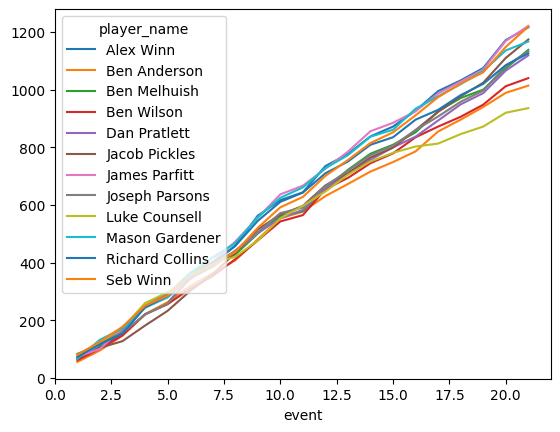

In [8]:
pivot_amagw_df = all_managers_all_gws_df.pivot_table(
    values="total_points", index="event", columns="player_name"
)
pivot_amagw_df.plot()

In [9]:
fig = px.line(
    all_managers_all_gws_df,
    x="event",
    y="total_points",
    color="player_name",
    markers=True,
)
fig.show()

## Make team selection matrix

### Open player data and make ID map

In [10]:
players_df = pd.read_csv(cwd + "/../data/external/players_raw.csv")
players_df.loc[:, ["id", "web_name"]]
id_name_dict = pd.Series(
    players_df["web_name"].values, index=players_df["id"]
).to_dict()
id_name_dict

{1: 'Balogun',
 2: 'Cédric',
 3: 'M.Elneny',
 4: 'Fábio Vieira',
 5: 'Gabriel',
 6: 'Havertz',
 8: 'G.Jesus',
 9: 'Jorginho',
 10: 'Kiwior',
 11: 'Marquinhos',
 12: 'Martinelli',
 13: 'Nketiah',
 14: 'Ødegaard',
 15: 'Thomas',
 16: 'Pepe',
 17: 'Ramsdale',
 18: 'Rúnarsson',
 19: 'Saka',
 20: 'Saliba',
 22: 'Smith Rowe',
 24: 'Tierney',
 25: 'Tomiyasu',
 26: 'Trossard',
 29: 'White',
 30: 'Xhaka',
 31: 'Zinchenko',
 113: 'Raya',
 540: 'Rice',
 578: 'Nelson',
 585: 'J.Timber',
 646: 'Hein',
 735: 'Sagoe',
 736: 'Walters',
 737: 'Ibrahim',
 764: 'Lewis-Skelly',
 772: 'Nwaneri',
 32: 'Alex Moreno',
 34: 'Bailey',
 35: 'Buendia',
 36: 'Cash',
 37: 'Chambers',
 38: 'Coutinho',
 39: 'Davis',
 40: 'Dendoncker',
 41: 'Diego Carlos',
 42: 'Digne',
 43: 'Douglas Luiz',
 44: 'Duran',
 45: 'Hause',
 46: 'Iroegbunam',
 47: 'Kamara',
 48: 'Konsa',
 49: 'Martinez',
 50: 'McGinn',
 51: 'Mings',
 53: 'Olsen',
 54: 'Philogene',
 55: 'J.Ramsey',
 56: 'Sanson',
 57: 'Sinisalo',
 58: 'Tielemans',
 59: 'Bert

### Do the same for manager_id

In [11]:
manager_id_name_dict = pd.Series(
    league_df["player_name"].values, index=league_df["entry"]
).to_dict()
manager_id_name_dict

{4651100: 'James Parfitt',
 7052472: 'Seb Winn',
 3794145: 'Alex Winn',
 3148659: 'Jacob Pickles',
 6963106: 'Mason Gardener',
 4075412: 'Ben Melhuish',
 4656770: 'Joseph Parsons',
 6911033: 'Richard Collins',
 3194123: 'Dan Pratlett',
 6083206: 'Ben Wilson',
 2709514: 'Ben Anderson',
 4371621: 'Luke Counsell'}

In [12]:
league_teams_df_list = []
league_picks_dict = {}
for manager_id in league_df["entry"].values:
    league_picks_dict[manager_id] = []
    for gw in range(1, 21):
        """if gw != 20:
        continue"""
        respose = requests.get(team_picks_template.format(manager_id=manager_id, gw=gw))
        team_selection_respose_json = respose.json()
        picks_df = pd.DataFrame(team_selection_respose_json["picks"])
        picks_df["element"] = picks_df["element"].map(id_name_dict)
        picks_df["manager_id"] = manager_id
        picks_df["gw"] = gw
        picks_df["status"] = np.where(
            picks_df["is_captain"] == True,
            "c",
            np.where(
                picks_df["is_vice_captain"] == True,
                "v",
                np.where(picks_df["multiplier"] == 0, "b", "p"),
            ),
        )
        league_teams_df_list.append(picks_df)
        league_picks_dict[manager_id] += list(
            (
                picks_df["element"]
                + "_"
                + picks_df["status"].astype(str)
                + "_"
                + picks_df["gw"].astype(str)
            ).values
        )


league_teams_df = pd.concat(league_teams_df_list).reset_index(drop=True)
league_picks_df = pd.DataFrame(league_picks_dict).rename(columns=manager_id_name_dict)

In [13]:
sim_df = jaccard_sim(league_picks_df)

In [14]:
colorscale = [
    [0, "rgba(61,23,90,255)"],
    [0.5, "rgba(70,160,246,255)"],
    [1, "rgba(72,250,137,255)"],
]
fig = px.imshow(
    sim_df, text_auto=False, aspect="auto", color_continuous_scale=colorscale
)
fig

In [15]:
league_teams_df

,element,position,multiplier,is_captain,is_vice_captain,manager_id,gw,status
0,Pickford,1,1,False,False,4651100,1,p
1,Estupiñan,2,1,False,False,4651100,1,p
2,Shaw,3,1,False,False,4651100,1,p
3,R.Lewis,4,1,False,False,4651100,1,p
4,B.Fernandes,5,1,False,False,4651100,1,p
...,...,...,...,...,...,...,...,...
3595,Wilson,11,1,False,False,4371621,20,p
3596,Areola,12,0,False,False,4371621,20,b
3597,Mbeumo,13,0,False,False,4371621,20,b
3598,Stones,14,0,False,False,4371621,20,b


In [16]:
league_picks_df

,James Parfitt,Seb Winn,Alex Winn,Jacob Pickles,Mason Gardener,Ben Melhuish,Joseph Parsons,Richard Collins,Dan Pratlett,Ben Wilson,Ben Anderson,Luke Counsell
0,Pickford_p_1,Onana_p_1,Pickford_p_1,Onana_p_1,Ederson M._p_1,Steele_p_1,Ramsdale_p_1,Onana_p_1,Onana_p_1,Steele_v_1,Steele_v_1,Steele_p_1
1,Estupiñan_p_1,Estupiñan_p_1,Estupiñan_p_1,Estupiñan_p_1,Chilwell_p_1,Udogie_p_1,Estupiñan_p_1,Trippier_p_1,Burn_p_1,Shaw_p_1,Colwill_p_1,Estupiñan_p_1
2,Shaw_p_1,Gabriel_p_1,Gabriel_p_1,Trippier_p_1,Saliba_p_1,Estupiñan_p_1,Botman_p_1,Estupiñan_p_1,Gabriel_p_1,Gabriel_p_1,J.Timber_p_1,Bell_p_1
3,R.Lewis_p_1,Chilwell_p_1,Shaw_p_1,Alexander-Arnold_p_1,Trippier_p_1,Shaw_p_1,Trippier_p_1,Alexander-Arnold_p_1,Estupiñan_p_1,Estupiñan_p_1,Baldock_p_1,Aké_p_1
4,B.Fernandes_p_1,Martinelli_p_1,Saka_p_1,Eze_p_1,Van Hecke_p_1,Alexander-Arnold_p_1,Saka_v_1,Mings_p_1,Saka_v_1,Rashford_p_1,Mitoma_p_1,B.Fernandes_v_1
...,...,...,...,...,...,...,...,...,...,...,...,...
295,Watkins_p_20,J.Alvarez_c_20,Watkins_v_20,Cunha_p_20,Watkins_p_20,Watkins_c_20,Solanke_p_20,J.Alvarez_p_20,J.Alvarez_p_20,Wilson_p_20,Solanke_p_20,Wilson_p_20
296,Turner_b_20,Dubravka_b_20,Dubravka_b_20,Turner_b_20,Areola_b_20,Dubravka_b_20,Strakosha_b_20,Sanchez_b_20,Dubravka_b_20,Neto_b_20,Turner_b_20,Areola_b_20
297,Archer_b_20,Colwill_b_20,Gusto_b_20,Isak_b_20,Woodrow_b_20,Gordon_b_20,Cash_b_20,Mitchell_b_20,L.Paquetá_b_20,Cash_b_20,Zinchenko_b_20,Mbeumo_b_20
298,Trippier_b_20,Gordon_b_20,Dalot_b_20,Gordon_b_20,Lascelles_b_20,Zinchenko_b_20,Udogie_b_20,Sarr_b_20,Solanke_b_20,Trippier_b_20,Trippier_b_20,Stones_b_20
